In [1]:
%load_ext autoreload
%autoreload 2
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
from tqdm import tqdm
import torch
from torch_geometric.data import Data
import os.path as osp

In [2]:
X, y = ef.qg_jets.load(-1, pad=False)

In [3]:

# the jet radius for these jets
R = 0.4

# process jets
#Gs, Qs = [], []
#for arr,events in [(Gs, X[y==0]), (Qs, X[y==1])]:
arr = []
events = X[y==1]
for i,x in tqdm(enumerate(events)):
    #if i >= num:
    #    break

    # ignore padded particles and removed particle id information
    x = x[x[:,0] > 0]

    # center jet according to pt-centroid
    yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
    x[:,1:3] -= yphi_avg

    # mask out any particles farther than R=0.4 away from center (rare)
    x = x[np.linalg.norm(x[:,1:3], axis=1) <= R]

    # add to list
    arr.append(x)

1000000it [01:26, 11563.85it/s]


In [4]:
total_jets = len(arr)

In [5]:
coords = arr[0][:, 1:3]
coords

array([[ 3.86938282e-01, -8.96080222e-03],
       [-2.25574422e-01, -2.00119039e-01],
       [-3.24029049e-02, -2.46494377e-01],
       [ 2.03721461e-01,  1.58759565e-02],
       [-1.82142653e-01,  4.65234801e-02],
       [-2.24429684e-02, -1.74751781e-01],
       [-3.75896507e-02, -1.04736224e-01],
       [ 7.43042418e-02,  1.56232675e-02],
       [ 7.22826387e-02,  4.38392266e-03],
       [ 2.03456353e-03, -1.49163178e-02],
       [ 6.27023925e-03,  8.56497981e-03],
       [ 3.03774117e-03,  9.62635413e-03],
       [ 2.80188347e-04,  1.09293218e-02],
       [-9.40388912e-03, -8.64861191e-04],
       [-6.56828790e-03, -4.15235478e-03],
       [-5.40773406e-03,  4.46504544e-03],
       [-2.52514112e-03,  5.11039679e-04],
       [-3.24119426e-03,  3.97092262e-03]])

In [6]:
def construct_edges_NN(X, n_neighbours):
    coords = X[:, 1:3]
    nbrs = NearestNeighbors(algorithm='kd_tree').fit(coords)
    if n_neighbours > coords.shape[0]: n_neighbours = coords.shape[0]
    nbrs_sm = nbrs.kneighbors_graph(coords, n_neighbours)
    nbrs_sm.setdiag(0) #remove self-loop edges
    nbrs_sm.eliminate_zeros()
    nbrs_sm = nbrs_sm + nbrs_sm.T
    edge_index = np.array(nbrs_sm.nonzero()).astype(np.int64)
    return edge_index

In [7]:
def construct_edges_R(X, R):
    coords = X[:, 0:3]
    tree = KDTree(coords) 
    nbrs = tree.query_radius(coords, R)
    ls, lt = [], []
    for s in range(len(nbrs)):
        for t in range(len(nbrs[s])):
            ls.append(s)
            lt.append(nbrs[s][t])
    edge_index = np.array([ls,lt])
    return edge_index   

## Visualise Single Jet

In [8]:
arr[0][:,0:3]

array([[ 2.68769142e-01,  3.86938282e-01, -8.96080222e-03],
       [ 1.60076377e-01, -2.25574422e-01, -2.00119039e-01],
       [ 1.14868731e+00, -3.24029049e-02, -2.46494377e-01],
       [ 4.13159146e+00,  2.03721461e-01,  1.58759565e-02],
       [ 1.69599701e+00, -1.82142653e-01,  4.65234801e-02],
       [ 2.19372581e+00, -2.24429684e-02, -1.74751781e-01],
       [ 1.61909680e+00, -3.75896507e-02, -1.04736224e-01],
       [ 6.59214883e+00,  7.43042418e-02,  1.56232675e-02],
       [ 3.77096258e+00,  7.22826387e-02,  4.38392266e-03],
       [ 1.34816345e+01,  2.03456353e-03, -1.49163178e-02],
       [ 4.10794493e+00,  6.27023925e-03,  8.56497981e-03],
       [ 2.16455176e+01,  3.03774117e-03,  9.62635413e-03],
       [ 6.77551168e+00,  2.80188347e-04,  1.09293218e-02],
       [ 1.32550803e+01, -9.40388912e-03, -8.64861191e-04],
       [ 2.98350842e+00, -6.56828790e-03, -4.15235478e-03],
       [ 3.73743866e+01, -5.40773406e-03,  4.46504544e-03],
       [ 3.35399046e+02, -2.52514112e-03

In [9]:
n_event = 2
ev = arr[n_event]

In [10]:
ev.shape #（n_components,[pt,y,phi,PID]）

(57, 4)

In [11]:
ev_edges = construct_edges_NN(ev,5)
#ev_edges = construct_edges_R(ev, 0.5)
ev_edges

array([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13,
        13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17,
        17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
        20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23,
        23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27,
        27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30,
        30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32,
        32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34,
        35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37,
        37, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 40, 

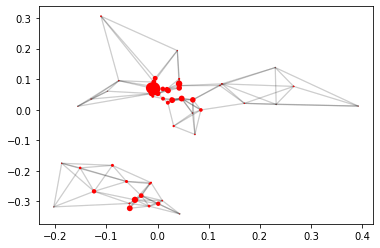

In [12]:
pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
plt.scatter(ys, phis, marker='o', s=2*pts, color='red', lw=0, zorder=10)

edge_from_ys = ev[:,1][ev_edges[0]]
edge_from_phis = ev[:,2][ev_edges[0]]
edge_to_ys = ev[:,1][ev_edges[1]]
edge_to_phis = ev[:,2][ev_edges[1]]
for i in range(edge_from_ys.shape[0]):
     plt.plot([edge_from_ys[i], edge_to_ys[i]], [edge_from_phis[i], edge_to_phis[i]], alpha=0.1, lw=1.25, color='black')

## Data Production

In [13]:
for jet_idx in tqdm(range(total_jets)):
    X = arr[jet_idx].astype('float32')
    edge_index = construct_edges_NN(X, 5)
    outdata = Data(x=torch.from_numpy(X),edge_index=torch.from_numpy(edge_index))
    torch.save(outdata, osp.join("data/processed", 'data_{}.pt'.format(jet_idx)))

100%|██████████| 1000000/1000000 [32:02<00:00, 520.04it/s]


## Verification

In [ ]:
from dataset import  FalconDataset
dataset = FalconDataset('')
dataset

In [2]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(dataset, batch_size=1)

In [51]:
a = dataset[0]

In [52]:
a

Data(edge_index=[2, 108], x=[18, 4])

In [53]:
b = dataset[100]

In [54]:
b

Data(edge_index=[2, 196], x=[32, 4])

In [56]:
ef.emd.emd(a.x[:,:3], b.x[:,:3])

50.06341457266163